# TODO LIST

- [x] Choose Amsterdam / Rotterdam via parameter
- [ ] Add Lags for remaining districts ('expanded' branch)
- [ ] Add / Replace `abs` values with `diff`
  - [x] Replace `lagged` variables with `diff`
  - [ ] Replace target variable with its `diff`
- [ ] Look-ahead values (e.g. 1 min 5 min 10 min 30 min) (tunable)
- [ ] Confusion Matrix per bin - find out model inaccuracies
- [ ] Add `LightGBM` model
- [ ] Benchmark accuracy, train-time, inference-time (in progress)
- [x] Add data from more than 1 days


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier

from helper import cyclic_encode

In [2]:
df = pd.read_csv("data/processed/most_crowded.csv").sort_values(by="timestamp")
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

df.head()

,timestamp,crowd
0,2024-04-15 09:56:45.102284431,247
1,2024-04-15 09:57:46.438505411,226
2,2024-04-15 09:58:48.041748047,211
3,2024-04-15 09:59:49.555481434,200
4,2024-04-15 10:00:51.375397921,176


## Feature Extraction

1. Binning
2. Feature Extraction
   1. Time-related Features
      1. Hour
      2. Minute
      3. Day of week
   2. Lagged Features
      1. 1-10 Minutes
      2. 15 Minutes
      3. 30 Minutes
      4. 60 Minutes
   3. Rolling Mean Features
      1. Mean
      2. Std
      3. Var
      4. Kurtosis
      5. Skewness
   4. Exponential Smoothing Features
      1. 5 Minutes
      2. 10 Minutes
      3. 15 Minutes
      4. 30 Minutes
      5. 60 Minutes
3. Cyclic Encoding


##### Binning


In [3]:
mean_crowd = df["crowd"].mean()
std_crowd = df["crowd"].std()

# Define bins based on mean and standard deviation
bins = [
    float("-inf"),
    mean_crowd - 1.0 * std_crowd,
    mean_crowd - 0.5 * std_crowd,
    mean_crowd + 0.5 * std_crowd,
    mean_crowd + 1.0 * std_crowd,
    float("inf"),
]

# Define labels for the bins
labels = list(range(len(bins) - 1))

In [4]:
df["c_lvl"] = pd.cut(
    df["crowd"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=True,
).astype(np.uint16)

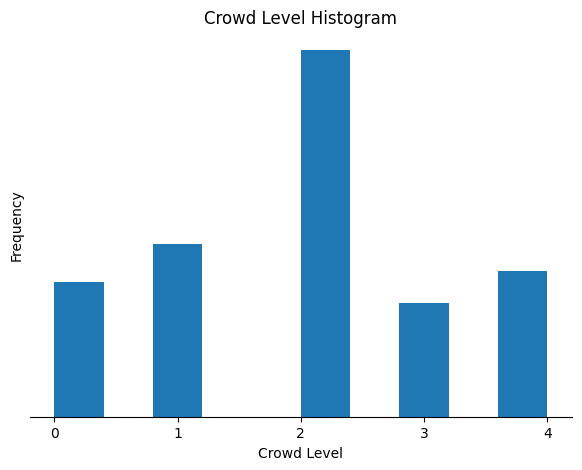

In [5]:
# Plot histogram of c_lvl in order to check if there is a class imbalance
df["c_lvl"].plot.hist(
    figsize=(7, 5),
    xlabel="Crowd Level",
    xticks=list(range(len(bins) - 1)),
    ylabel="Frequency",
    title="Crowd Level Histogram",
)
plt.gca().get_yaxis().set_ticks([])
plt.gca().spines[["left", "top", "right"]].set_visible(False)
plt.show()

Time-related Feature Extraction


In [6]:
# Time-related features
time_related_features = {
    "hour": df["timestamp"].dt.hour.astype(np.uint8),
    "day_of_week": df["timestamp"].dt.day_of_week.astype(np.uint8),
    "minute": df["timestamp"].dt.minute.astype(np.uint8),
    "is_weekend": (df["timestamp"].dt.weekday >= 5).astype(np.uint8),
}

Lagged and Rolling Feature Extraction


In [7]:
# Lagged features
lagged_features = {
    f"lag_{i}": df["crowd"].shift(i).diff() for i in list(range(1, 11)) + [15, 30, 60]
}

# Rolling features
rolling_features = {
    f"rolling_{stat}_{window}": getattr(df["crowd"].rolling(window=window), stat)()
    for window in [5, 10, 15, 30, 60]
    for stat in ["mean", "std", "var", "skew", "kurt"]
}

# Exponential smoothing
exp_smoothing_features = {
    f"ema_{window}": df["crowd"].ewm(span=window, adjust=True).mean()
    for window in [5, 10, 15, 30, 60]
}

In [8]:
# After feature extraction we don't need the original "crowd" column
df.drop(columns=["crowd"], inplace=True)

lagged_df = (
    pd.concat(
        [
            df,
            pd.DataFrame(lagged_features),
            pd.DataFrame(rolling_features),
            pd.DataFrame(exp_smoothing_features),
            pd.DataFrame(time_related_features),
        ],
        axis=1,
    )
    .set_index("timestamp")
    .dropna()
)
lagged_df = cyclic_encode(lagged_df, "minute", 60)
lagged_df = cyclic_encode(lagged_df, "hour", 24)
lagged_df = cyclic_encode(lagged_df, "day_of_week", 7)

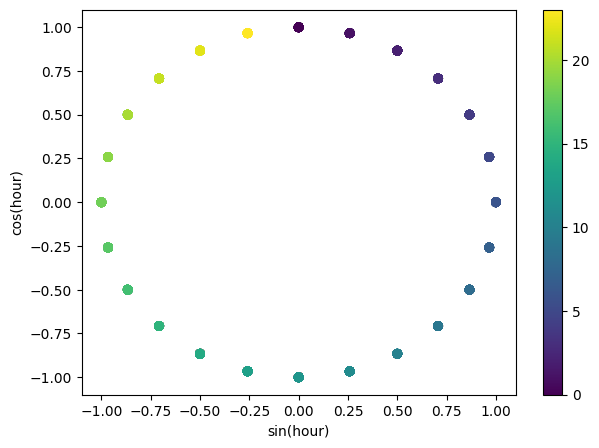

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(lagged_df["hour_sin"], lagged_df["hour_cos"], c=lagged_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

In [10]:
lagged_df.drop(columns=["minute", "hour", "day_of_week"], inplace=True)

#### Data Splitting


In [11]:
X = lagged_df.drop(columns=["c_lvl"])
y = lagged_df["c_lvl"]

### Model Training

1. Pipeline Construction
2. Hyperparameter Tuning
3. Time Series Cross Validation


In [12]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

#### Pipeline Construction


In [13]:
num_features = X_train.select_dtypes(include=[np.float64, np.uint16]).columns.tolist()

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_features),
        ("one-hot", OneHotEncoder(handle_unknown="ignore"), ["is_weekend"]),
    ],
    remainder="passthrough",
)

# Define the pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("estimator", XGBClassifier(random_state=42)),
    ]
)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_15', 'lag_30',
                                                   'lag_60', 'rolling_mean_5',
                                                   'rolling_std_5',
                                                   'rolling_var_5',
                                                   'rolling_skew_5',
                                                   'rolling_kurt_5',
                                                   'rolling_mean_10',
                                                   'rolling_std_10',
                                                   'rolling...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

##### Grid Search


In [15]:
param_grid = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [2, 3],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__colsample_bytree": [0.5, 0.7, 0.8],
    "estimator__reg_lambda": [0.3, 0.5, 0.7],
}

In [16]:
ts_cv = TimeSeriesSplit(n_splits=5)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_micro": make_scorer(f1_score, average="micro"),
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ts_cv,
    scoring=scoring,
    refit="f1_micro",
    n_jobs=1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters:")
for key, value in grid_search.best_params_.items():
    print(f"    - {key.split('__')[-1]}: {value}")

cv_results = grid_search.cv_results_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best score: 0.581
Best parameters:
    - colsample_bytree: 0.8
    - learning_rate: 0.1
    - max_depth: 3
    - n_estimators: 200
    - reg_lambda: 0.3


Best parameters:

- colsample_bytree: 0.7
- learning_rate: 0.1
- max_depth: 3
- n_estimators: 50
- reg_lambda: 0.3


In [17]:
best_model = grid_search.best_estimator_

In [35]:
importances = (
    pd.DataFrame(data=[X_train.columns, best_model[1].feature_importances_])
    .T.rename(
        {
            0: "feature",
            1: "importance",
        },
        axis=1,
    )
    .sort_values(by="importance")
)

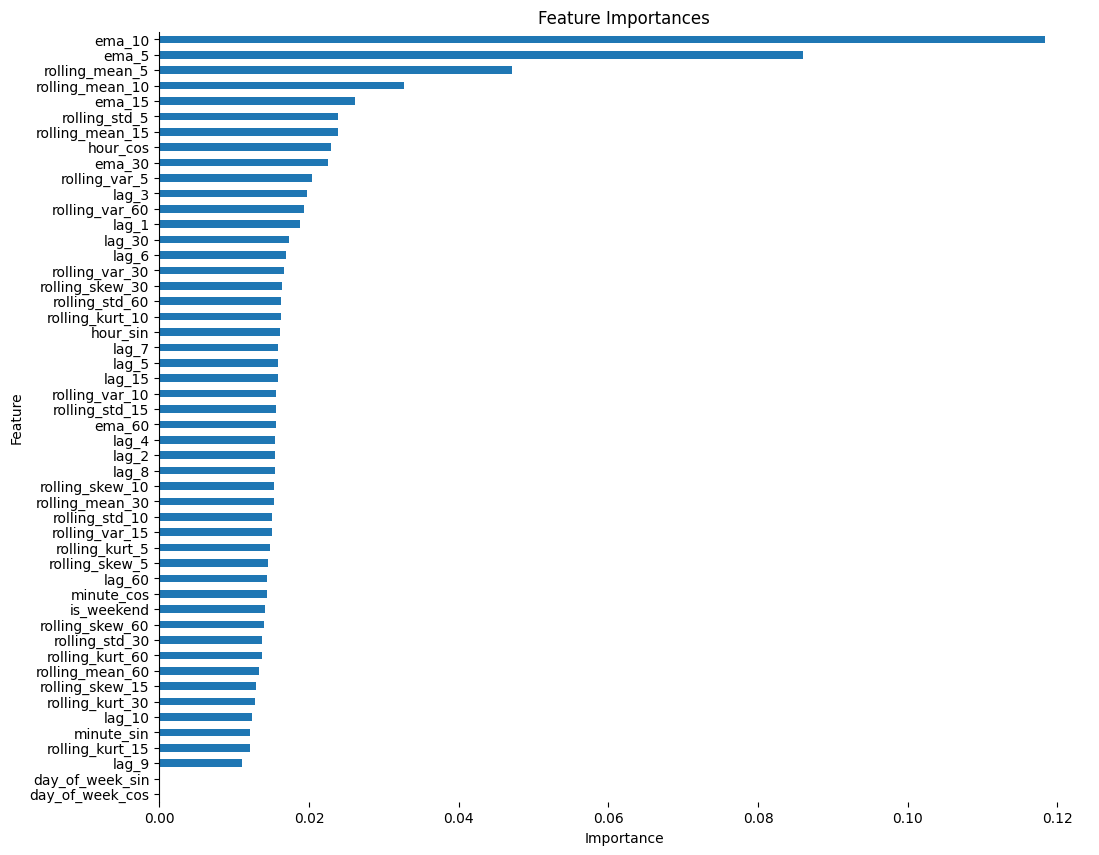

In [42]:
importances.plot.barh(x="feature", y="importance", figsize=(12, 10))
plt.title("Feature Importances")
plt.legend().set_visible(False)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().spines[["right", "bottom", "top"]].set_visible(False)
plt.show()
plt.show()

In [25]:
for key, value in cv_results.items():
    if key.startswith(("mean_test", "test")):
        metric = key.split("_")[-1]
        print(f"{metric}: {value.mean():.3f} ± {value.std():.3f}")

accuracy: 0.854 ± 0.010
micro: 0.854 ± 0.010


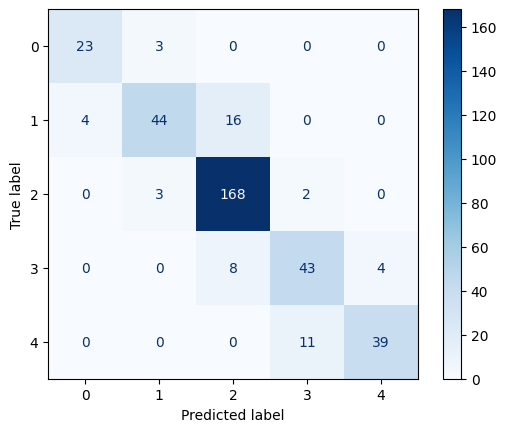

In [26]:
y_pred = best_model.predict(X_test)
_ = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")

In [27]:
print(
    classification_report(
        y_test,
        y_pred,
        digits=3,
        target_names=["very_low", "low", "medium", "high", "very_high"],
    )
)

              precision    recall  f1-score   support

    very_low      0.852     0.885     0.868        26
         low      0.880     0.688     0.772        64
      medium      0.875     0.971     0.921       173
        high      0.768     0.782     0.775        55
   very_high      0.907     0.780     0.839        50

    accuracy                          0.861       368
   macro avg      0.856     0.821     0.835       368
weighted avg      0.863     0.861     0.858       368



# Model Evaluation

1. w/ `Feature Selection` (34 Features)
   1. Diff Lags + Rolling Stats
      1. Accuracy: 0.492 ± 0.010
      2. F1: 0.360 ± 0.027
   2. Diff Lags + Rolling Stats + EMA
      1. Accuracy: 0.484 ± 0.009
      2. F1: 0.339 ± 0.028
2. w/out `Feature Selection` (52 Features)
   1. Diff Lags + Rolling Stats + EMA
      1. Accuracy: 0.854 ± 0.01
      2. F1-Micro: {0.854 ± 0.01}
